In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def load_data(path_to_archive: str):
    spark = SparkSession.builder.getOrCreate()
    # Загрузка CSV датасета из HDFS
    df = spark.read.option("sep",",").option("header","true").option("inferSchema","true").csv(path_to_archive)
    # Предобработка данных
    # Удаление ненужных столбцов
    df = df.drop('_c0','trans_date_trans_time',"cc_num","merchant",
    'first', 'last', "lat","long",'street',"city","gender","job",
    "city_pop",'state', 'zip','dob', 'trans_num', 'unix_time'
    )
    # Drop rows with null values if any
    df = df.dropna()
    return df

def get_indexation(df):
    # Индексация категориальных признаков
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['category', 'job']]
    pipeline = Pipeline(stages=indexers)
    df = pipeline.fit(df).transform(df)
    df = df.drop("category", 'job')
    # Индексация целевой переменной
    label_indexer = StringIndexer(inputCol="is_fraud", outputCol="label")
    df = label_indexer.fit(df).transform(df)
    return df

def mix_data(df, limit_1: int, limit_0: int):
    from pyspark.sql.functions import rand
    # Делаем выборку нужных данных
    error_truc = df.where(df["is_fraud"] == 1).select("*").limit(limit_1)
    good_truc = df.where(df["is_fraud"] == 0).select("*").limit(limit_0)
    # Объединяем их вместе
    combined_dataframe = error_truc.union(good_truc)
    # Перемешиваем данные случайно
    df_randomized = combined_dataframe.orderBy(rand())
    return df_randomized

def generate_cat_to_binary_vector(df):
# Преобразование категориальных признаков в бинарные векторы
    encoder = OneHotEncoder(inputCols=["category_index", "job_index"], outputCols=["category_vec", "job_vec"])
    df = encoder.fit(df).transform(df)
    return df

def collect_signs_to_vector(df):
# Сборка признаков в один вектор
    assembler = VectorAssembler(inputCols=["amt", "category_vec", "merch_lat", "merch_long", "job_vec"], outputCol="features")
    df = assembler.transform(df)
    return df

def evaluator(predictions):
# Создание экземпляра оценщика
    evaluator = BinaryClassificationEvaluator()
    # Вычисление точности
    accuracy = evaluator.evaluate(predictions)
    # Вывод точности
    print(f'Точность модели: {accuracy:.2f}')

# ---------------------------------------------------------------
def lern_logistic_reg(trainingData):
    # Обучение модели
    logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
    classifier = logReg.fit(trainingData)
    return classifier

def lern_linear_SVC(trainingData):
# Обучение модели
    LinSVC = LinearSVC(maxIter=10, regParam=0.1)
    classifier = LinSVC.fit(trainingData)
    return classifier

def lern_DTC(trainingData):
# Обучение модели
    DTC = DecisionTreeClassifier(maxDepth=5)
    classifier = DTC.fit(trainingData)
    return classifier

def lern_RFC(trainingData):
    # Обучение модели
    RFC = RandomForestClassifier(numTrees=10)
    classifier = RFC.fit(trainingData)
    return classifier

def lern_GBT(trainingData):
    # Обучение модели
    GBT = GBTClassifier(maxIter=10)
    classifier = GBT.fit(trainingData)
    return classifier

# -------------------------------------------------------------------
def get_prediction(classifier, test_data):
    # Получение предсказания
    predictions = classifier.transform(test_data)
    return predictions
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
# from pyspark.ml.classification import LinearSVC
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# import matplotlib.pyplot as plt
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# def load_data(path_to_archive: str):
#     spark = SparkSession.builder.getOrCreate()
#     # Загрузка CSV датасета из HDFS
#     df = spark.read.option("sep",",").option("header","true").option("inferSchema","true").csv(path_to_archive)
#     # Предобработка данных
#     # Удаление ненужных столбцов
#     df = df.drop('_c0','trans_date_trans_time',"cc_num","merchant",
#     'first', 'last', "lat","long",'street','city','gender',
#     "city_pop",'state', 'zip','dob', 'trans_num', 'unix_time',
#     )
#     # Drop rows with null values if any
#     df = df.dropna()
#     return df

# def get_indexation(df):
#     # Индексация категориальных признаков
#     indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['category', 'job']]
#     pipeline = Pipeline(stages=indexers)
#     df = pipeline.fit(df).transform(df)
#     df = df.drop("category", 'job')
#     # Индексация целевой переменной
#     label_indexer = StringIndexer(inputCol="is_fraud", outputCol="label")
#     df = label_indexer.fit(df).transform(df)
#     return df

# def mix_data(df, limit_1: int, limit_0: int):
#     from pyspark.sql.functions import rand
#     # Делаем выборку нужных данных
#     error_truc = df.where(df["is_fraud"] == 1).select("*").limit(limit_1)
#     good_truc = df.where(df["is_fraud"] == 0).select("*").limit(limit_0)
#     # Объединяем их вместе
#     combined_dataframe = error_truc.union(good_truc)
#     # Перемешиваем данные случайно
#     df_randomized = combined_dataframe.orderBy(rand())
#     return df_randomized

# def generate_cat_to_binary_vector(df):
#     # Преобразование категориальных признаков в бинарные векторы
#     encoder = OneHotEncoder(inputCols=["category_index", "job_index"], outputCols=["category_vec", "job_vec"])
#     df = encoder.fit(df).transform(df)
#     return df

# def collect_signs_to_vector(df):
#     # Сборка признаков в один вектор
#     assembler = VectorAssembler(inputCols=["amt", "category_vec", "merch_lat", "merch_long", "job_vec"], outputCol="features")
#     df = assembler.transform(df)
#     return df

# def evaluator(predictions):
#     # Создание экземпляра оценщика
#     evaluator = BinaryClassificationEvaluator()
#     # Вычисление точности
#     accuracy = evaluator.evaluate(predictions)
#     # Вывод точности
#     print(f'Точность модели: {accuracy:.2f}')

# def lern_logistic_reg(trainingData):
#     # Обучение модели
#     logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
#     classifier = logReg.fit(trainingData)
#     return classifier

# def lern_linear_SVC(trainingData):
#     # Обучение модели
#     LinSVC = LinearSVC(maxIter=10, regParam=0.1)
#     classifier = LinSVC.fit(trainingData)
#     return classifier

# def lern_DTC(trainingData):
#     # Обучение модели
#     DTC = DecisionTreeClassifier(maxDepth=5)
#     classifier = DTC.fit(trainingData)
#     return classifier

# def lern_RFC(trainingData):
# # Обучение модели
#     RFC = RandomForestClassifier(numTrees=10)
#     classifier = RFC.fit(trainingData)
#     return classifier

# def lern_GBT(trainingData):
# # Обучение модели
#     GBT = GBTClassifier(maxIter=10)
#     classifier = GBT.fit(trainingData)
#     return classifier

# def get_prediction(classifier, test_data):
#     # Получение предсказания
#     predictions = classifier.transform(test_data)
#     return predictions


In [2]:
train_data = load_data("archive/fraudTrain.csv")
test_data = load_data("archive/fraudTest.csv")

train_data_index = get_indexation(train_data)
test_data_index = get_indexation(test_data)

trainDF = mix_data(train_data_index,limit_1 = 7500,limit_0 = 15000)
testDF = mix_data(test_data_index,limit_1 = 2000,limit_0 = 10000)

train_assembler = generate_cat_to_binary_vector(trainDF)
test_assembler = generate_cat_to_binary_vector(testDF)


# Итоговые DF
result_train = collect_signs_to_vector(train_assembler)
result_test = collect_signs_to_vector(test_assembler)

Py4JJavaError: An error occurred while calling o80.fit.
: org.apache.spark.SparkException: Input column job does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


Посмотреть на данные

Общее кол во записей

В тренировочном датасете находится около 1500 тыщ мошеннических и 5000 обычных.

Если что можно поменять соотношение данных

Соотношение данных тренировочных

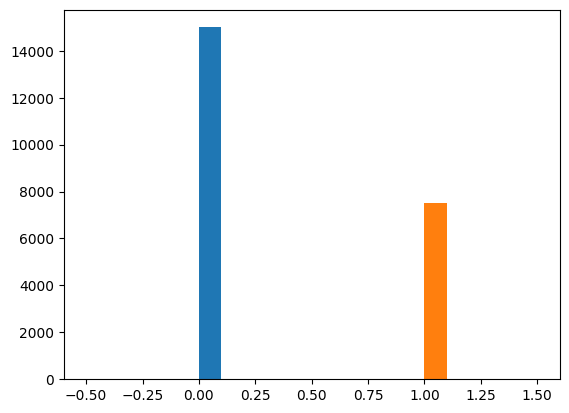

In [ ]:
true_data = trainDF.where(trainDF["label"] == 0.0).select("label").toPandas()
false_data = trainDF.where(trainDF["label"] == 1.0).select("label").toPandas()

fig, axs = plt.subplots(1,1)
# We can set the number of bins with the *bins* keyword argument.
axs.hist(true_data)
axs.hist(false_data)
plt.show()


Соотношение данных тестовых

In [ ]:
true_data = testDF.where(testDF["label"] == 0.0).select("label").toPandas()
false_data = testDF.where(testDF["label"] == 1.0).select("label").toPandas()

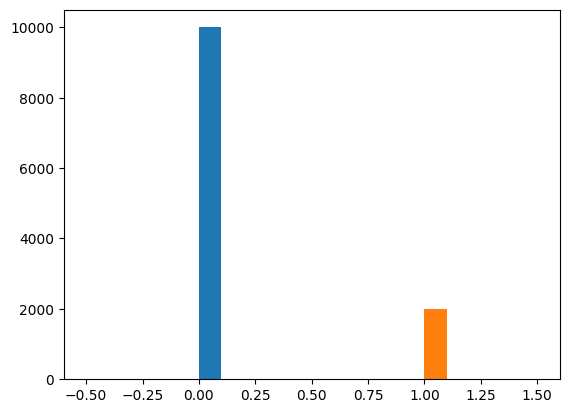

In [ ]:
fig, axs = plt.subplots(1,1)
# We can set the number of bins with the *bins* keyword argument.
axs.hist(true_data)
axs.hist(false_data)
plt.show()


Какие зависимости есть

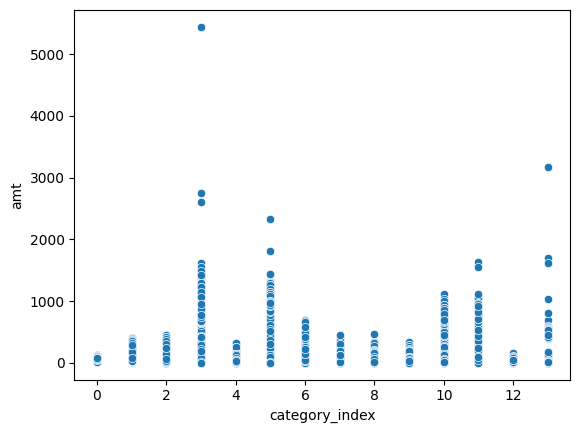

In [ ]:
import seaborn as sns
# Зависимость amt от категории
ax = sns.scatterplot(data= trainDF.toPandas(),y = "amt",x = "category_index")


<Axes: xlabel='job_index', ylabel='amt'>

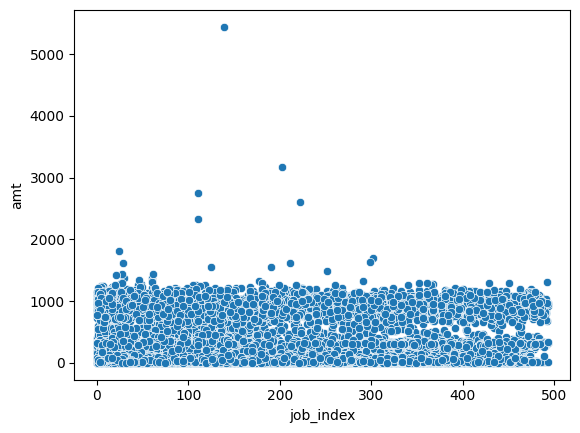

In [ ]:
# Зависимость amt от работы
sns.scatterplot(data= trainDF.toPandas(),y = "amt",x = "job_index")

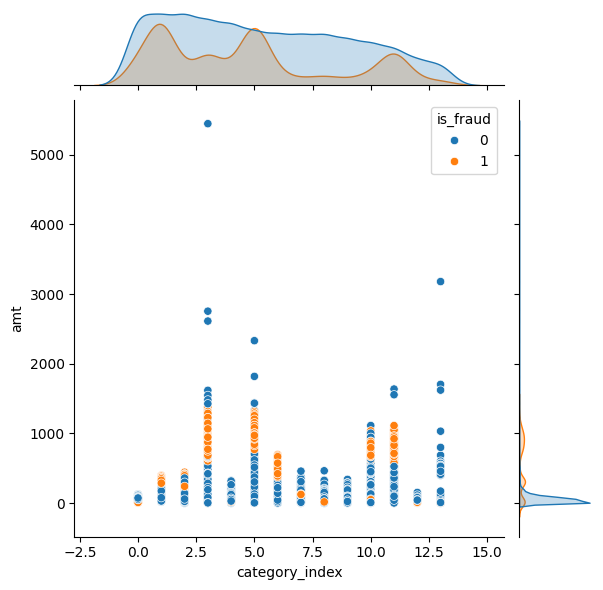

In [ ]:
# Хороший график я бы оставил
sns.jointplot(data= trainDF.toPandas(),x = "category_index",y = "amt", hue = "is_fraud")

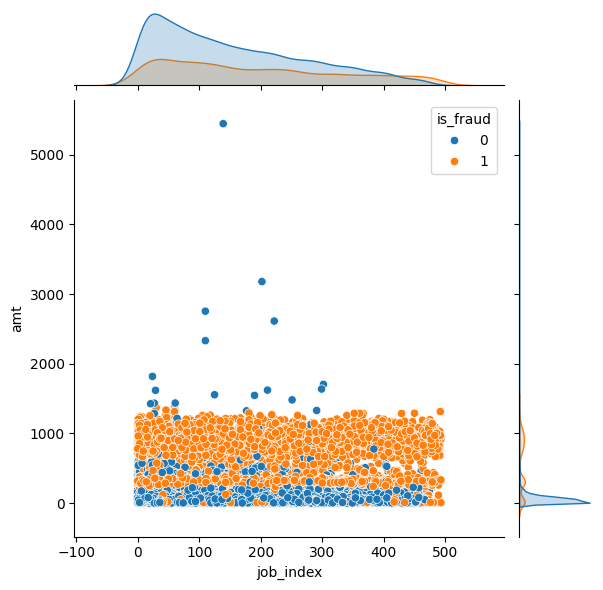

In [ ]:
sns.jointplot(data= trainDF.toPandas(),x = "job_index",y = "amt", hue = "is_fraud")

Тестовая выборка

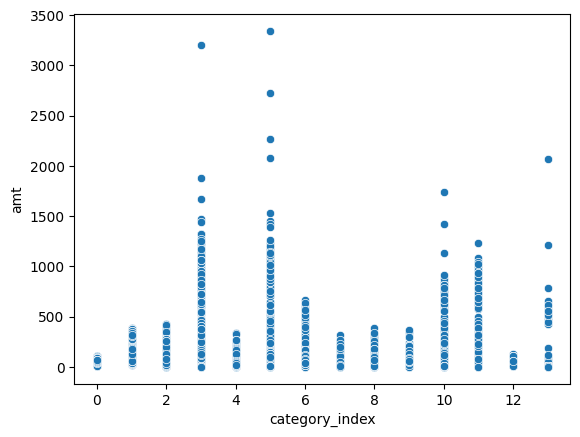

In [ ]:
ax = sns.scatterplot(data= testDF.toPandas(),y = "amt",x = "category_index")

<Axes: xlabel='job_index', ylabel='amt'>

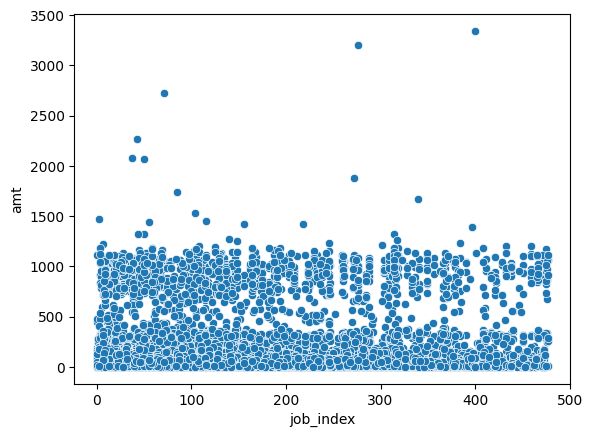

In [ ]:
# Зависимость amt от работы
sns.scatterplot(data= testDF.toPandas(),y = "amt",x = "job_index")

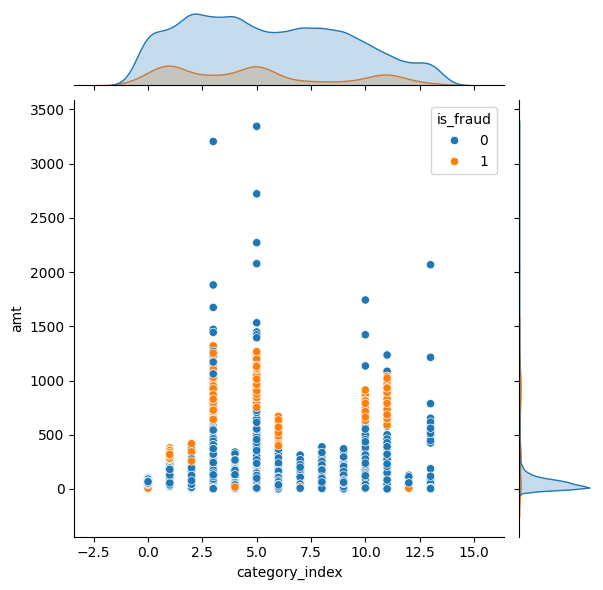

In [ ]:
# Хороший график я бы оставил
sns.jointplot(data= testDF.toPandas(),x = "category_index",y = "amt", hue = "is_fraud")

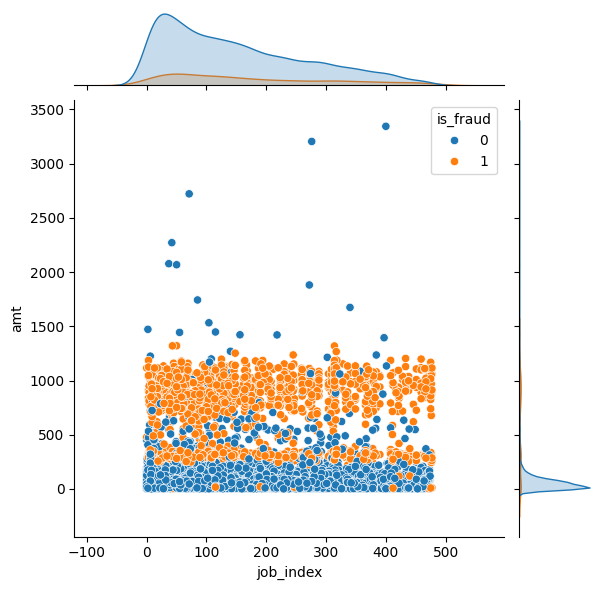

In [ ]:
sns.jointplot(data= testDF.toPandas(),x = "job_index",y = "amt", hue = "is_fraud")

----------------------------------------

Обучение моделей

In [ ]:
logistic = lern_logistic_reg(result_train)
prediction_data_1 = get_prediction(classifier=logistic, test_data=result_test)

In [ ]:
liner_SVC = lern_linear_SVC(result_train)
prediction_data_2 = get_prediction(classifier=liner_SVC, test_data=result_test)

In [ ]:
DTC = lern_DTC(result_train)
prediction_data_3 = get_prediction(classifier=DTC, test_data=result_test)

In [ ]:
RFC = lern_RFC(result_train)
prediction_data_4 = get_prediction(classifier=RFC, test_data=result_test)

In [ ]:
GBT = lern_GBT(result_train)
prediction_data_5 = get_prediction(classifier=GBT, test_data=result_test)

In [ ]:
y_true = prediction_data_1.select("label").collect()
y_pred = prediction_data_1.select("prediction").collect()

y_true_2 = prediction_data_2.select("label").collect()
y_pred_2 = prediction_data_2.select("prediction").collect()

y_true_3 = prediction_data_3.select("label").collect()
y_pred_3 = prediction_data_3.select("prediction").collect()

y_true_4 = prediction_data_4.select("label").collect()
y_pred_4 = prediction_data_4.select("prediction").collect()

y_true_5 = prediction_data_5.select("label").collect()
y_pred_5 = prediction_data_5.select("prediction").collect()

Py4JJavaError: An error occurred while calling o2215.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1528.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1528.0 (TID 2418) (LAPTOP-3Q2TP7T4 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda/0x0000017d82506000`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 493, y.size = 509
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1151)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1150)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1241)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1060)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4148)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4145)
	at jdk.internal.reflect.GeneratedMethodAccessor140.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda/0x0000017d82506000`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 493, y.size = 509
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1151)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1150)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1241)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1060)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more


In [ ]:
result_test

DataFrame[amt: double, merch_lat: double, merch_long: double, is_fraud: int, category_index: double, job_index: double, label: double, category_vec: vector, job_vec: vector, features: vector]

In [ ]:
result_train

DataFrame[amt: double, merch_lat: double, merch_long: double, is_fraud: int, category_index: double, job_index: double, label: double, category_vec: vector, job_vec: vector, features: vector]

In [ ]:
prediction_data_1.select("*").show(n=20, truncate=True, vertical=False)

Py4JJavaError: An error occurred while calling o4377.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3029.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3029.0 (TID 4831) (LAPTOP-3Q2TP7T4 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda/0x00000204384f92d0`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 493, y.size = 509
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1151)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1150)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1241)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1060)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3314)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3537)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at jdk.internal.reflect.GeneratedMethodAccessor223.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda/0x00000204384f92d0`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage6.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 493, y.size = 509
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1(LogisticRegression.scala:1151)
	at org.apache.spark.ml.classification.LogisticRegressionModel.$anonfun$margin$1$adapted(LogisticRegression.scala:1150)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1241)
	at org.apache.spark.ml.classification.LogisticRegressionModel.predictRaw(LogisticRegression.scala:1060)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more


Проверка

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def heat_map(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True)
    plt.xlabel("prediction")
    plt.ylabel("True")


heat_map(y_true,y_pred)


NameError: name 'y_pred' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.    0.006 1.   ] [0.    0.007 1.   ] [inf  1.  0.]


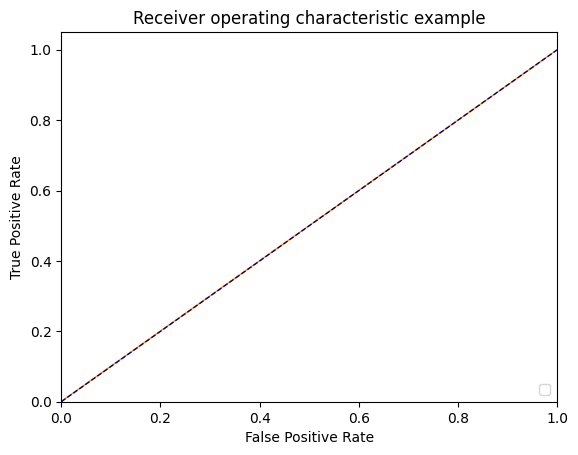

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.     0.0588 1.    ] [0.     0.7175 1.    ] [inf  1.  0.]


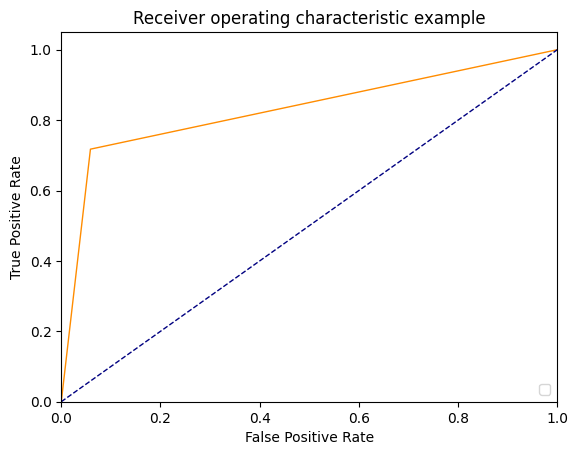

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.     0.0165 1.    ] [0.    0.814 1.   ] [inf  1.  0.]


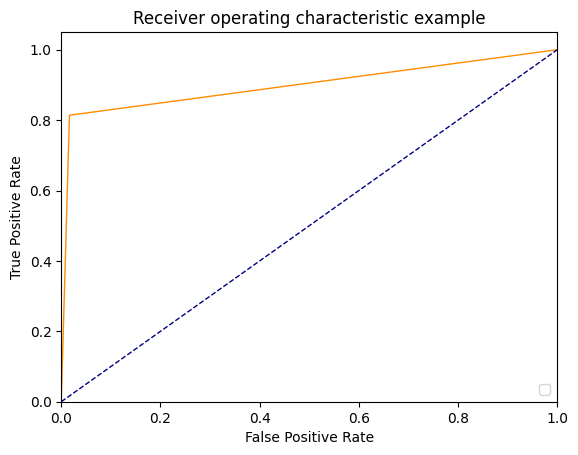

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.    0.032 1.   ] [0.    0.728 1.   ] [inf  1.  0.]


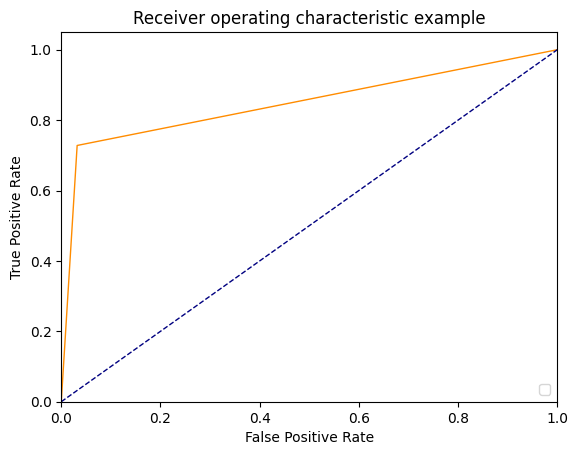

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.     0.0212 1.    ] [0.     0.8415 1.    ] [inf  1.  0.]


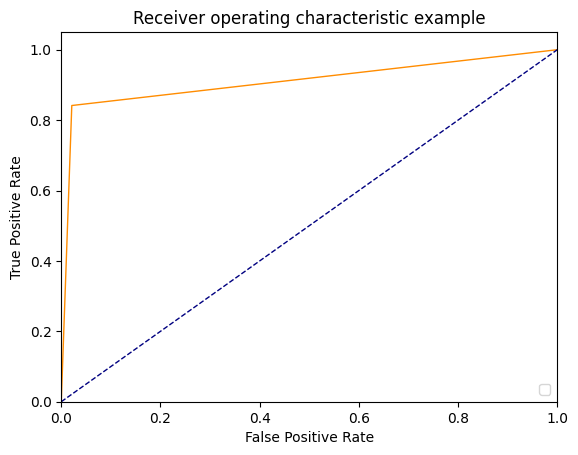

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt



def ROC(y_true,y_pred):
    # Получаем точки на ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print( fpr, tpr, thresholds)
    # Рисуем ROC-кривую
    plt.figure(1)
    lw = 1
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw,)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()



ROC(y_true,y_pred)
ROC(y_true_2,y_pred_2)
ROC(y_true_3,y_pred_3)
ROC(y_true_4,y_pred_4)
ROC(y_true_5,y_pred_5)

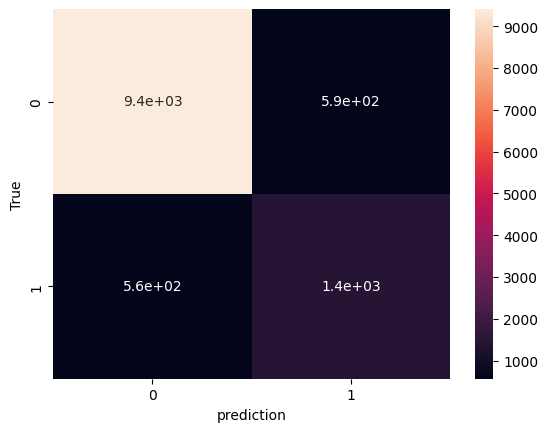

In [ ]:
heat_map(y_true_2,y_pred_2)


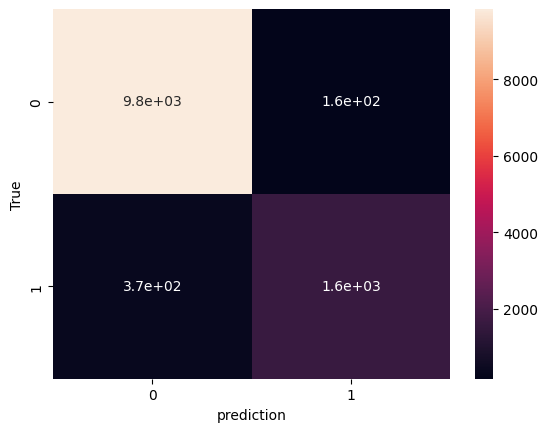

In [ ]:
heat_map(y_true_3,y_pred_3)


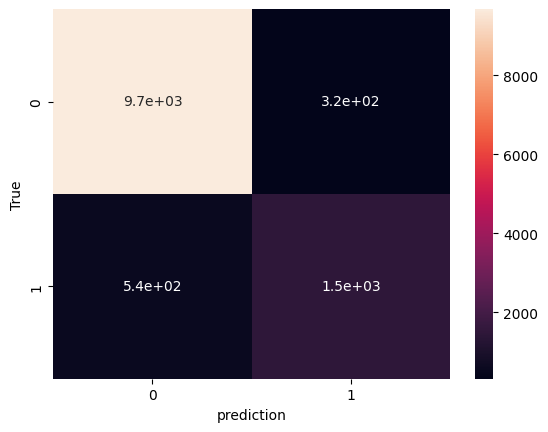

In [ ]:
heat_map(y_true_4,y_pred_4)


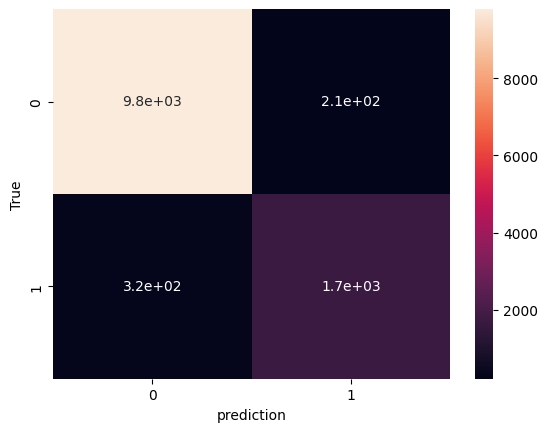

In [ ]:
heat_map(y_true_5,y_pred_5)

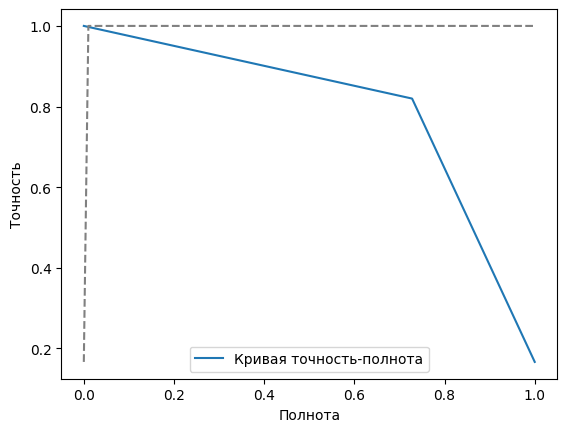

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Предположим, что y_true - это истинные значения класса, а y_pred - это предсказанные значения класса
precision, recall, thresholds = precision_recall_curve(y_true_4, y_pred_4)

# Создаем кривую "точность-полнота"
plt.plot(recall, precision, label='Кривая точность-полнота')

# Добавляем точки, где точность равна полноте
interp_precision = np.interp(np.linspace(0, 1, 100), recall, precision)
plt.plot(np.linspace(0, 1, 100), interp_precision, '--', color='grey')

# Добавляем метки на оси
plt.xlabel('Полнота')
plt.ylabel('Точность')

# Подписываем легенду
plt.legend()

# Показываем график
plt.show()